# Trabajo práctico n° 2
## Evolución del salario joven

Integrantes:
- Mazo, Luis
- Hoj, Agustín
- Nacucchio, Illed

El objetivo de este programa es analizar la evolución del salario joven desde el 2007 hasta la actualidad y predecir cómo seguirá evolucionando el año entrante. Además, se propone hacer comparaciones sobre la valoración de cada sector de trabajo. Para ello contamos con tres datasets: uno que contiene los datos sobre el salario en distintos sectores desde el 2007 hasta junio del 2023 y dos que contienen los valores de conversión a dólar del peso argentino desde el 2003 a la actualidad tanto Oficial como Blue. Además, contamos con un dataset de apoyo del que extraeremos un diccionario con la información de los sectores de trabajo que se tienen en consideración.

### Librerías

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
warnings.filterwarnings(action='ignore')

### Preparación del DataFrame de Salario joven y el diccionario de Sectores

In [2]:
# Primero preparamos el dataframe donde quedará almacenado el dataset sobre salario joven, ofrecido por fuentes gubernamentales.
def salarios():
    dfSalarios = pd.read_csv("salario_joven.csv")
    dfSalarios.rename(columns={
        'fecha': 'Fecha',
        'clae2': 'Sector',
        'w_median': 'Sueldo Promedio'},
        inplace=True
    )
    return dfSalarios

dfSalarios = salarios()

# Luego generamos un diccionario con la información correspondiente a cada sector de trabajo incluido en el dataset
# Cargamos el dataset en un DataFrame
dfSectores = pd.read_csv('clae_agg.csv')
# Creamos el diccionario a partir de las columnas clae2 y clae2_desc, que se corresponden al ID del sector y su nombre
sectores_descripcion = dict(zip(dfSectores['clae2'], dfSectores['clae2_desc']))

In [3]:
# Previsualización del dataframe
print(dfSalarios)

# Previsualización del diccionario
print("Referencias de cada sector: ")
for clave, valor in sectores_descripcion.items():
    print(f"{clave}: {valor}")

            Fecha  Sector  Sueldo Promedio
0      2007-01-01     999              687
1      2007-01-01       1              800
2      2007-01-01       2              736
3      2007-01-01       3             1473
4      2007-01-01       5              999
...           ...     ...              ...
16910  2023-07-01      92           193317
16911  2023-07-01      93           116402
16912  2023-07-01      94           176101
16913  2023-07-01      95           134212
16914  2023-07-01      96            98154

[16915 rows x 3 columns]
Referencias de cada sector: 
1: Agricultura, ganadería, caza y servicios relacionados
2: Silvicultura y explotación forestal
3: Pesca y acuicultura
5: Extracción de carbón y lignito
6: Extracción de petróleo crudo y gas natural
7: Extracción de minerales metálicos
8: Extracción de otros minerales
9: Actividades de apoyo al petróleo y la minería
10: Elaboración de productos alimenticios
11: Elaboración de bebidas
12: Elaboración de productos de tabaco
13:

### Funciones para navegar y analizar las estadísticas de nuestro DataFrame

- Comparador de sectores

In [61]:
# Construimos una función para buscar una palabra clave en el diccionario de Sectores y hallar los datos dentro del dataframe
def buscar_sectores(df, sectores_dic, palabra_clave):
    # Filtramos los sectores que contienen la palabra clave (ambas se transforman a minúsculas para aproximar la similitud)
    sectores_coincidentes = [sector for sector, nombre in sectores_dic.items() if palabra_clave.lower() in nombre.lower()]

    # Imprimimos el número y el valor asociado a los sectores coincidentes del diccionario
    print("Sectores que coinciden con la palabra clave:")
    for i, sector in enumerate(sectores_coincidentes):
        print(f"{sector}: {sectores_dic[sector]}")

    # Filtramos el DataFrame para obtener las filas con los sectores coincidentes
    df_coincidentes = df[df['Sector'].isin(sectores_coincidentes)]
    
    return df_coincidentes

# Construimos una función que genere el gráfico que pondrá en comparasión todos los sectores que contengan esa palabra clave
def generar_grafico(df):
    # Agrupamos por sector y calculamos el salario promedio
    salario_promedio_por_sector = df.groupby('Sector')['Sueldo Promedio'].mean().sort_values(ascending=False)

    # Creamos un gráfico de barras
    plt.figure(figsize=(15, 8))
    salario_promedio_por_sector.plot(kind='bar', color='skyblue')
    
    # Configuramos el gráfico y los textos que lo acompañan
    plt.title('Salario Promedio por Sector en los últimos 16 años')
    plt.xlabel('Sector')
    plt.ylabel('Salario Promedio')
    plt.xticks(rotation=45, ha='right')

    plt.show()

def buscador():
    palabra_clave = input("Ingrese la clave de búsqueda:")
    df_resultado = buscar_sectores(dfSalarios, sectores_descripcion, palabra_clave)

    # Imprimimos el gráfico en función de la palabra clave
    generar_grafico(df_resultado)


Sectores que coinciden con la palabra clave:
19: Fabricación de productos de refinación de petróleo
20: Fabricación de sustancias químicas
22: Fabricación de productos de caucho y plástico
23: Fabricación de productos de vidrio y otros minerales no metálicos
24: Fabricación de metales comunes
25: Fabricación de productos elaborados del metal, excepto maquinaria y equipo
26: Fabricación de productos de informática, de electrónica y de óptica
27: Fabricación de equipo eléctrico
28: Fabricación de maquinarias
29: Fabricación de vehículos automotores, remolques y semirremolques
30: Fabricación de otros equipos de transporte
31: Fabricación de muebles


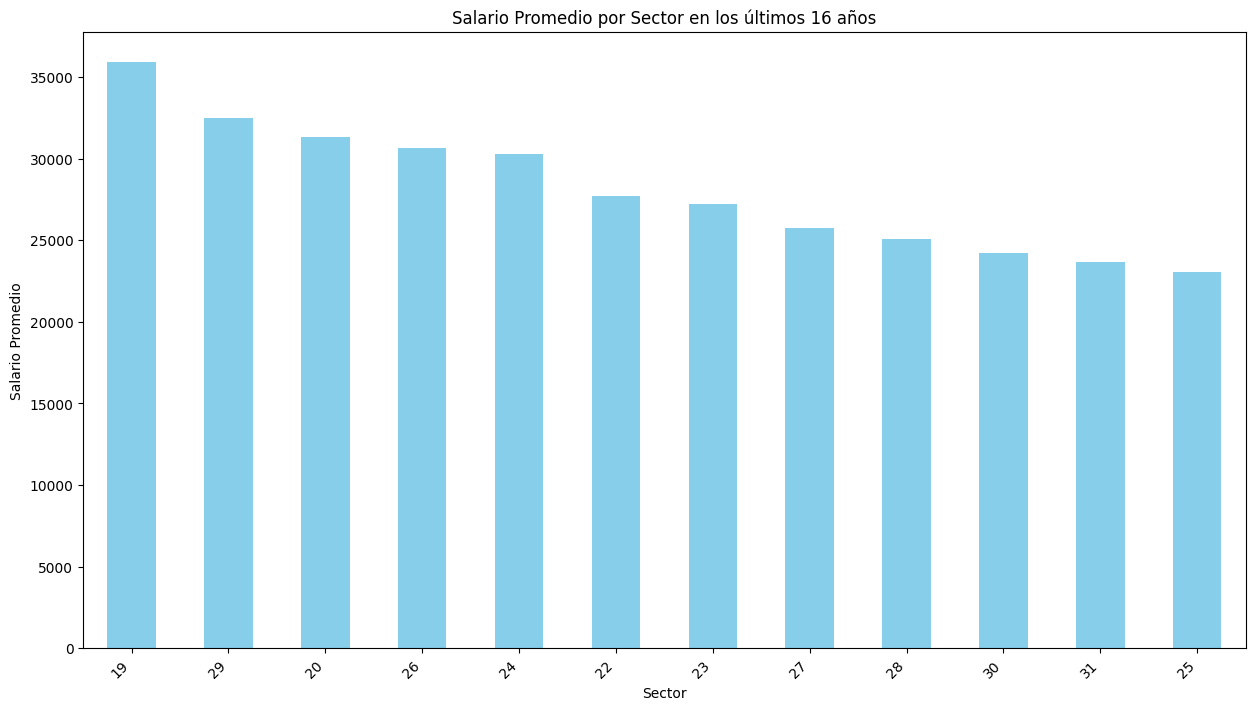

In [62]:
buscador()

# Con la palabra clave "Fabricación" podemos ver que la Fabricación de productos de refinación de petróleo
# tiene un salario promedio considerablemente mayor que cualquier otra clase de producto fabricado

- Evolución del salario en un sector específico:

Usted ha elegido  Elaboración de prendas de vestir
                              Fecha  Sector  Sueldo Promedio
Fecha                                                       
2007  2007-06-16 12:00:00.000000000    14.0      1174.166667
2008  2008-06-16 08:00:00.000000000    14.0      1494.166667
2009  2009-06-16 12:00:00.000000000    14.0      1827.000000
2010  2010-06-16 12:00:00.000000000    14.0      2425.250000
2011  2011-06-16 12:00:00.000000000    14.0      3322.416667
2012  2012-06-16 08:00:00.000000000    14.0      4297.333333
2013  2013-06-16 12:00:00.000000000    14.0      5392.000000
2014  2014-06-16 12:00:00.000000000    14.0      7190.000000
2015  2015-06-16 12:00:00.000000000    14.0      8909.166667
2016  2016-06-16 08:00:00.000000000    14.0     12067.083333
2017  2017-06-16 12:00:00.000000000    14.0     15505.916667
2018  2018-06-16 12:00:00.000000000    14.0     18915.833333
2019  2019-06-16 12:00:00.000000000    14.0     25757.750000
2020  2020-06-16 08:00:00.00000000

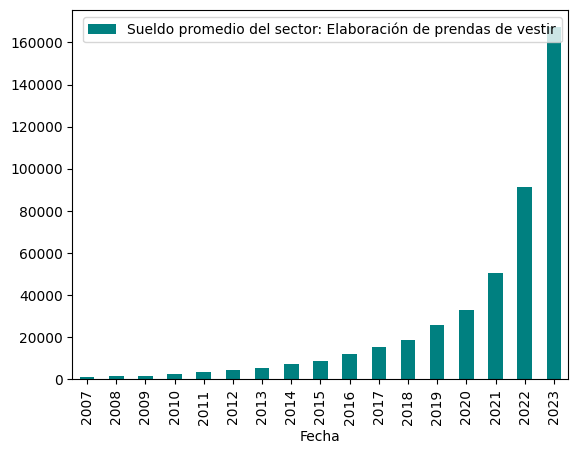

In [58]:
# Creamos una función que busca el sector de trabajo y emite una tabla con el sueldo promedio anual de dicho sector
# y genera un gráfico de barras que muestra la evolución en el tiempo
def salario_por_anio(_sector):
    print("Usted ha elegido ", sectores_descripcion[_sector])
    # Transformamos los datos de la columna Fecha a tipo de dato: fecha
    dfSalarios['Fecha'] = pd.to_datetime(dfSalarios.Fecha, format='%Y-%m-%d')

    # Filtramos por el sector seleccionado los datos de cada año
    dfSalariosFiltrado = dfSalarios.loc[dfSalarios['Sector'] == _sector]
    anio = dfSalariosFiltrado['Fecha'].dt.year

    # Agrupamos por año y calculamos el promedio de sueldo entre todos los meses
    dfSalariosFiltrado=dfSalariosFiltrado.groupby(anio).mean()
    print(dfSalariosFiltrado.head(20))

    # Configuramos el gráfico
    leyenda = "Sueldo promedio del sector: " + sectores_descripcion[_sector]
    dfSalariosFiltrado['Sueldo Promedio'].plot.bar(color='teal',legend=True, label=leyenda)

# Interfaz para que el usuario ingrese el sector de trabajo
sector = int(input("Ingresar el Sector de trabajo como figura en su valor numérico:"))
salario_por_anio(sector)

- Comparador de salario mensual en cada sector por salario mínimo vital y móvil mensual:

In [55]:
# Primero creamos un dataframe con los datos del dataset de Salario Mínimo Vital Móvil
dfSalarioMinimo = pd.read_csv("indice-salario-minimo-vital-movil-pesos-corrientes.csv")
# Modificamos los nombres de las columnas para hacerlos más manejables
dfSalarioMinimo.rename(columns={
        'indice_tiempo': 'Fecha',
        'salario_minimo_vital_movil_mensual': 'SMVM mensual',
        'salario_minimo_vital_movil_diario' : 'SMVM diario',
        'salario_minimo_vital_movil_hora' : 'SMVM hora'},
        inplace=True
    )

# Filtramos el DataFrame para eliminar las filas anteriores al año 2007
dfSalarioMinimo['Fecha'] = pd.to_datetime(dfSalarioMinimo['Fecha'])
dfSalarioMinimo = dfSalarioMinimo[dfSalarioMinimo['Fecha'].dt.year >= 2007]

# Previsualización del DataFrame resultante
print("Salario mínimo vital móvil en pesos corrientes: \n", dfSalarioMinimo)

Salario mínimo vital móvil en pesos corrientes: 
          Fecha  SMVM mensual  SMVM diario  SMVM hora
504 2007-01-01         800.0         32.0        4.0
505 2007-02-01         800.0         32.0        4.0
506 2007-03-01         800.0         32.0        4.0
507 2007-04-01         800.0         32.0        4.0
508 2007-05-01         800.0         32.0        4.0
..         ...           ...          ...        ...
703 2023-08-01      112500.0       4500.0      562.5
704 2023-09-01      118000.0       4720.0      590.0
705 2023-10-01      132000.0       5280.0      660.0
706 2023-11-01      146000.0       5840.0      730.0
707 2023-12-01      156000.0       6240.0      780.0

[204 rows x 4 columns]


In [56]:
# Luego creamos las funciones que nos permitirán hacer una búsqueda, una comparación y emitir un gráfico

def comparar_svmv_sueldo(df_sueldos, df_svmv, year, month):
    df_sueldos['Fecha'] = pd.to_datetime(df_sueldos['Fecha'])
    # Filtramos por año y mes
    df_sueldos_filtered = df_sueldos[(df_sueldos['Fecha'].dt.year == year) & (df_sueldos['Fecha'].dt.month == month)]
    df_svmv_filtered = df_svmv[(df_svmv['Fecha'].dt.year == year) & (df_svmv['Fecha'].dt.month == month)]

    # Agregamos columnas de año y mes a ambos DataFrames
    df_sueldos_filtered['Año'] = df_sueldos_filtered['Fecha'].dt.year
    df_sueldos_filtered['Mes'] = df_sueldos_filtered['Fecha'].dt.month

    df_svmv_filtered['Año'] = df_svmv_filtered['Fecha'].dt.year
    df_svmv_filtered['Mes'] = df_svmv_filtered['Fecha'].dt.month

    # Calculamos el Sueldo Promedio mensual por sector
    sueldo_promedio_mensual = df_sueldos_filtered.groupby(['Año', 'Mes', 'Sector'])['Sueldo Promedio'].mean().reset_index()

    # Comparamos el Sueldo Promedio mensual con el SVMV mensual
    resultado_comparacion = pd.merge(sueldo_promedio_mensual, df_svmv_filtered, on=['Año', 'Mes'], how='left')
    resultado_comparacion.drop(['SMVM diario', 'SMVM hora'], axis=1, inplace=True)
    return resultado_comparacion

def grafico_comparativo_sueldo_svmv(df_comparacion, year, month):
    # Filtramos por año y mes
    df_comparacion_filtered = df_comparacion[(df_comparacion['Año'] == year) & (df_comparacion['Mes'] == month)]
    # Filtramos el Sector 999: Otros porque dificulta la lectura del gráfico
    df_comparacion_filtered = df_comparacion_filtered[df_comparacion_filtered['Sector'] != 999]
    # Configuramos el gráfico con un ancho razonable para una lectura eficaz
    plt.figure(figsize=(20, 10))
    plt.bar(df_comparacion_filtered['Sector'], df_comparacion_filtered['Sueldo Promedio'], label='Sueldo Promedio', color='teal')
    plt.plot(df_comparacion_filtered['Sector'], df_comparacion_filtered['SMVM mensual'], marker='o', linestyle='-', color='orange', label='SMVM mensual')
    
    # Añadimos texto al gráfico
    plt.xticks(df_comparacion_filtered['Sector'], df_comparacion_filtered['Sector'])
    plt.xlabel('Sector')
    plt.ylabel('Monto')
    plt.title(f'Comparación de Sueldo Promedio y SMVM mensual - {year}/{month}')
    plt.legend()
    
    plt.show()

def buscadorSMVM():
    anio_clave = int(input("Ingrese el año de búsqueda:"))
    mes_clave = int(input("Ingrese el mes:"))
    resultado_comparacion = comparar_svmv_sueldo(dfSalarios, dfSalarioMinimo, anio_clave, mes_clave)

    # A partir de los datos buscados, imprimimos un gráfico
    grafico_comparativo_sueldo_svmv(resultado_comparacion, anio_clave, mes_clave)

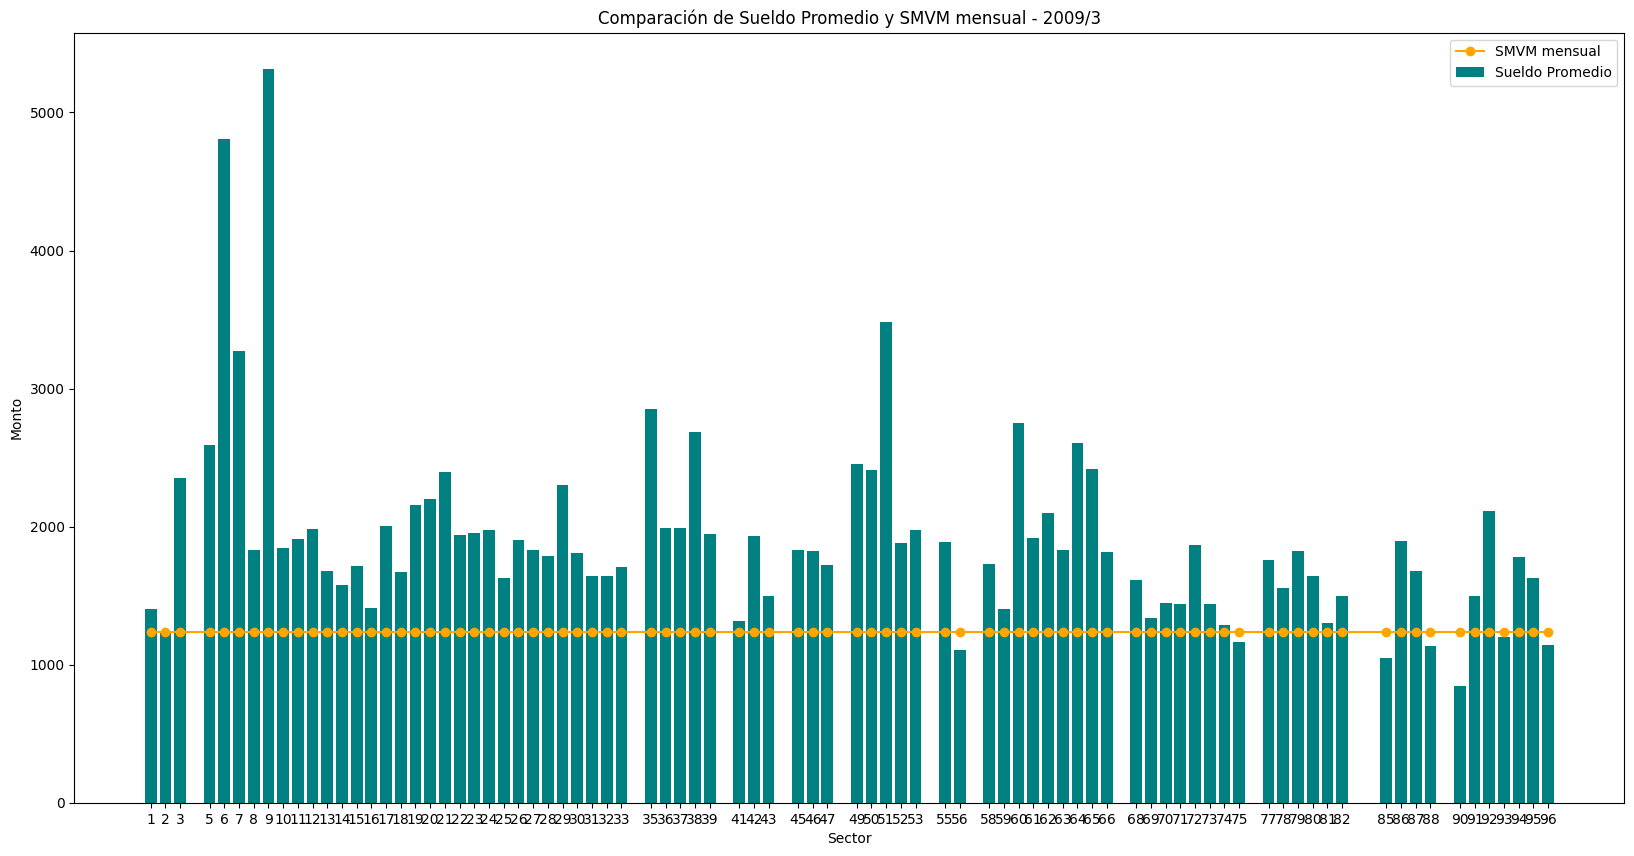

In [57]:
buscadorSMVM()

# Si buscamos marzo del 2009, por ejemplo, podemos ver que los tres sueldos promedios más altos son:

# 9: Actividades de apoyo al petróleo y la minería, 6: Extracción de petróleo crudo y gas natural y 51: Transporte Aéreo,
# en ese orden, seguidos por 7: Extracción de minerales metálicos, 35: Suministro de electricidad, gas, vapor y aire acondicionado
# y 60: Programación y transmisiones de TV y radio. Es decir que las dos actividades mejores remuneradas están dedicadas al petróleo
# y entre las 6 mejor remuneradas, 3 están vinculadas a la extracción y 3 a la producción de energía.
# En cuanto a aquellos que están por debajo del salario mínimo, de menor a mayor nos encontramos con:
# 90: Servicios artísticos y de espectáculos, 85: Enseñanza, 56: Servicios de expendio de alimentos y bebidas,
# 88: Actividades de atención sin alojamiento, 96: Otros servicios personales y 75: Servicios veterinarios.


In [69]:
# Función que devuelve el nombre del sector basado en su número, para facilitar la lectura del gráfico anterior
def buscar_sector(_sector):
    print(_sector, ":", sectores_descripcion[_sector])

sector_a_buscar = int(input("Número del sector que desea buscar en el diccionario:"))
buscar_sector(sector_a_buscar)

75 : Servicios veterinarios


### Predicciones

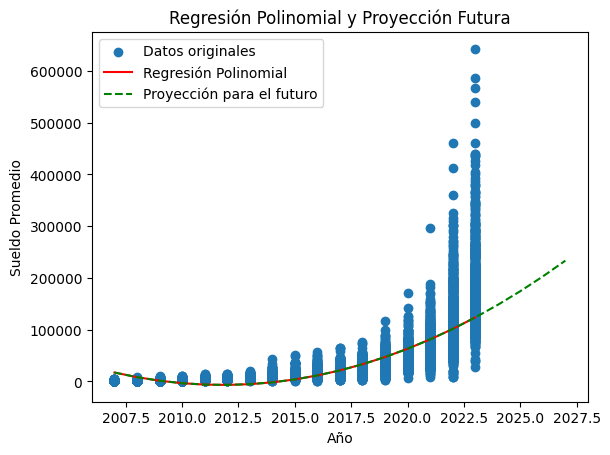

Predicción de salario promedio joven para el año 2025: $174,242.63


In [62]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Agregamos una columna de año
dfSalarios['Año'] = dfSalarios['Fecha'].dt.year

X = dfSalarios[['Año']].values
y = dfSalarios['Sueldo Promedio'].values

# Dividimos los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Trabajamos con polinomios porque al hacer un gráfico de recta comprobamos que nuestros datos hacían una curva
grado_polinomio = 2

# Creamos el modelo de regresión polinomial
modelo_polinomial = make_pipeline(PolynomialFeatures(degree=grado_polinomio), LinearRegression())

# Ajustamos el modelo en todo el conjunto de datos
modelo_polinomial.fit(X, y)

# Predecimos el salario para los datos originales
y_pred = modelo_polinomial.predict(X)

# Predecimos el salario para valores de años futuros (para graficar la proyección)
años_futuros = np.arange(X.min(), X.max() + 5).reshape(-1, 1)  # proyección para 5 años adicionales
y_pred_futuro = modelo_polinomial.predict(años_futuros)

# Graficamos los datos originales y la regresión polinomial
plt.scatter(X, y, label='Datos originales')
plt.plot(X, y_pred, label='Regresión Polinomial', color='red')
plt.plot(años_futuros, y_pred_futuro, label='Proyección para el futuro', linestyle='--', color='green')
plt.xlabel('Año')
plt.ylabel('Sueldo Promedio')
plt.title('Regresión Polinomial y Proyección Futura')
plt.legend()
plt.show()

# Prevemos el salario para el año pedido
anio = input("Año que desea predecir:")
sueldo_proximo_anio = modelo_polinomial.predict([[anio]])

print(f"Predicción de salario promedio joven para el año {anio}: ${sueldo_proximo_anio[0]:,.2f}")

In [63]:
# Ajustamos el modelo en el conjunto de entrenamiento
modelo_polinomial.fit(X_train, y_train)

# Realizamos predicciones en el conjunto de prueba
y_pred_polinomial = modelo_polinomial.predict(X_test)

# Calculamos métricas de evaluación
mse_polinomial = mean_squared_error(y_test, y_pred_polinomial)
rmse_polinomial = np.sqrt(mse_polinomial)
r2_polinomial = r2_score(y_test, y_pred_polinomial)

print("Mean Squared Error (MSE) - Regresión Polinomial:", mse_polinomial)
print("Root Mean Squared Error (RMSE) - Regresión Polinomial:", rmse_polinomial)
print("R² en conjunto de prueba - Regresión Polinomial:", r2_polinomial)

Mean Squared Error (MSE) - Regresión Polinomial: 714438717.5443345
Root Mean Squared Error (RMSE) - Regresión Polinomial: 26728.986466836606
R² en conjunto de prueba - Regresión Polinomial: 0.6585727632479923


### Conversiones a dólar

In [63]:
# Construimos una función para generar un promedio por mes de cada año de la conversión del dólar oficial y dólar blue
def calcular_tasa_promedio_mensual(csv_file, _encoding):
    # Columnas que deseamos leer (en este caso, las dos primeras); son las que necesitamos y las demás generan conflictos en su lectura
    columns_to_read = ['Fecha', 'Último']

    # Cargamos el CSV utilizando solo las columnas especificadas
    dfDolar = pd.read_csv(csv_file, sep=',', encoding=_encoding, usecols=columns_to_read)

    # Convertimos la 'Fecha' a tipo datetime
    dfDolar['Fecha'] = pd.to_datetime(dfDolar['Fecha'], dayfirst=True)
        
    # Convertimos 'Último' a tipo numérico, ignorando los errores
    dfDolar['Último'] = pd.to_numeric(dfDolar['Último'], errors='coerce')
        
    # Por si acaso, eliminamos filas con valores no numéricos
    dfDolar = dfDolar.dropna(subset=['Último'])
        
    # Creamos columnas adicionales para año y mes
    dfDolar['Año'] = dfDolar['Fecha'].dt.year
    dfDolar['Mes'] = dfDolar['Fecha'].dt.month

    # Modificamos el nombre de la columna 'Último'
    dfDolar = dfDolar.rename(columns={'Último': 'Conversión promedio'})

    # Calculamos el promedio mensual de conversión
    promedio_mensual = dfDolar.groupby(['Año', 'Mes'])['Conversión promedio'].mean().reset_index()
    
    return promedio_mensual # Lo devolvemos

# Dólar oficial
promedioOficial = calcular_tasa_promedio_mensual('datos_historicos-ARS_USD.csv', 'UTF-8')
print("Oficial:\n", promedioOficial)

# Dólar blue
promedioBlue = calcular_tasa_promedio_mensual('datos-historicos-USD_ARSB.csv', 'latin-1')
print("Blue:\n", promedioBlue)

Oficial:
       Año  Mes  Conversión promedio
0    2007    1             0.324170
1    2007    2             0.322330
2    2007    3             0.322491
3    2007    4             0.323576
4    2007    5             0.324687
..    ...  ...                  ...
198  2023    7             0.003754
199  2023    8             0.003129
200  2023    9             0.002860
201  2023   10             0.002860
202  2023   11             0.002860

[203 rows x 3 columns]
Blue:
       Año  Mes  Conversión promedio
0    2007    1             3.104783
1    2007    2             3.115500
2    2007    3             3.119091
3    2007    4             3.117619
4    2007    5             3.113478
..    ...  ...                  ...
198  2023    7           517.710526
199  2023    8           669.318182
200  2023    9           735.750000
201  2023   10           907.875000
202  2023   11           912.500000

[203 rows x 3 columns]


In [64]:
def salario_a_dolar(_df, tipo_dolar):

    _df['Fecha'] = pd.to_datetime(_df['Fecha'], dayfirst=True)

    # Crear columnas adicionales para año y mes en dfSalarios
    _df['Año'] = _df['Fecha'].dt.year
    _df['Mes'] = _df['Fecha'].dt.month

    if tipo_dolar == "Oficial":
        # Unir dfSalarios con el promedio_mensual del dólar oficial
        _df = pd.merge(_df, promedioOficial, on=['Año', 'Mes'], how='left')
        # Calcular el equivalente del salario en dólares oficiales
        _df['Salario en dólar oficial'] = _df['Sueldo Promedio'] * _df['Conversión promedio']
    elif tipo_dolar == "Blue":
        # Unir dfSalarios con el promedio_mensual del dólar blue
        _df = pd.merge(_df, promedioBlue, on=['Año', 'Mes'], how='left')
        # Calcular el equivalente del salario en dólares blue
        _df['Salario en dólar blue'] = _df['Sueldo Promedio'] / _df['Conversión promedio']

    # Eliminamos la columna 'Fecha' y 'Conversión promedio'
    _df = _df.drop(['Fecha', 'Conversión promedio'], axis=1)

    # Mostrar el DataFrame resultante
    return _df

# Ejemplo de uso
salarios_dolar_oficial = salario_a_dolar(dfSalarios, tipo_dolar="Oficial")
print("Salario en dólar Oficial:\n", salarios_dolar_oficial)

salarios_dolar_blue = salario_a_dolar(dfSalarios, tipo_dolar="Blue")
print("Salario en dólar Blue:\n", salarios_dolar_blue)

Salario en dólar Oficial:
        Sector  Sueldo Promedio   Año  Mes  Salario en dólar oficial
0         999              687  2007    1                222.704491
1           1              800  2007    1                259.335652
2           2              736  2007    1                238.588800
3           3             1473  2007    1                477.501770
4           5              999  2007    1                323.845396
...       ...              ...   ...  ...                       ...
16910      92           193317  2023    1               1060.958845
16911      93           116402  2023    1                638.835340
16912      94           176101  2023    1                966.474306
16913      95           134212  2023    1                736.579858
16914      96            98154  2023    1                538.686998

[16915 rows x 5 columns]
Salario en dólar Blue:
        Sector  Sueldo Promedio   Año  Mes  Salario en dólar blue
0         999              687  2007    1 

# Espacio interactivo

- Calculadora conversión de pesos a dólar oficial y blue según el año y el mes elegidos:

Convertir a una sola función como hice con la de arriba ^^^

In [65]:
# Calculadora
def convertir_a_dolares(monto, año, mes, tasa_promedio_mensual):
    # Filtro el DataFrame para obtener la tasa de cambio correspondiente al año y mes especificados
    filtro = (tasa_promedio_mensual['Año'] == año) & (tasa_promedio_mensual['Mes'] == mes)

    if filtro.any():  # Verifico si hay al menos una fila después de aplicar el filtro
        tasa_cambio = tasa_promedio_mensual.loc[filtro, 'Conversión promedio'].values[0]
        # Realizo la conversión
        monto_en_dolares = monto * tasa_cambio
        return monto_en_dolares
    else:
        print(f"No hay datos disponibles para el año {año} y mes {mes}.")
        return None
    
def convertir_a_dolaresB(monto, año, mes, tasa_promedio_mensual):
    # Filtro el DataFrame para obtener la tasa de cambio correspondiente al año y mes especificados
    filtro = (tasa_promedio_mensual['Año'] == año) & (tasa_promedio_mensual['Mes'] == mes)

    if filtro.any():  # Verifico si hay al menos una fila después de aplicar el filtro
        tasa_cambio = tasa_promedio_mensual.loc[filtro, 'Conversión promedio'].values[0]
        # Realizo la conversión
        monto_en_dolares = monto / tasa_cambio
        return monto_en_dolares
    else:
        print(f"No hay datos disponibles para el año {año} y mes {mes}.")
        return None

In [66]:
# A dólar oficial
def convertidor_peso_dolar():   
    tasa_promedio_mensual = calcular_tasa_promedio_mensual('datos_historicos-ARS_USD.csv', 'UTF-8')

    monto_pesos = int(input("Monto de pesos argentinos que desea convertir a dólares:"))
    año_conversion = int(input("El año en el que se desea calcular la conversión:"))
    mes_conversion = int(input("El mes en el que se desea calcular la conversión:"))

    monto_dolares = convertir_a_dolares(monto_pesos, año_conversion, mes_conversion, tasa_promedio_mensual)
    if monto_dolares is not None:
        print(f'{monto_pesos} pesos argentinos eran aproximadamente {monto_dolares:.2f} dólares americanos en cambio oficial el 15/{mes_conversion}/{año_conversion}.')
    else:
        print("No se pudo realizar la conversión. Verifica los datos disponibles.")

    # A dólar blue

    tasa_promedio_mensual = calcular_tasa_promedio_mensual('datos-historicos-USD_ARSB.csv', 'latin-1')

    monto_dolaresB = convertir_a_dolaresB(monto_pesos, año_conversion, mes_conversion, tasa_promedio_mensual)
    if monto_dolaresB is not None:
        print(f'{monto_pesos} pesos argentinos eran aproximadamente {monto_dolaresB:.2f} dólares americanos blue el 15/{mes_conversion}/{año_conversion}.')
    else:
        print("No se pudo realizar la conversión. Verifica los datos disponibles.")

- Conocer el promedio del salario de cada sector por año:

Reparar después de los cambios ^^^^

In [79]:
class Menu:
    def __init__(self):
        self.acceso_menu = True

    def mostrar_menu(self):
        while self.acceso_menu:
            opcion_elegida = int(input('Ingrese el número de la opción del menú que desee elegir:\n1. Generar un gráfico del salario joven promedio anual basado en sector laboral\n2. Convertir de peso a dolar basado en mes y año\n3. Comparar el salario de 2 sectores diferentes \n0. SALIR\n\n'))
            opciones_disponibles = self.retornar_opciones_menu()
            if opcion_elegida in opciones_disponibles:
                opciones_disponibles[opcion_elegida]()
            else:
                print(f"No se encontró la opción {opcion_elegida}, intente con un valor válido como {list(opciones_disponibles.keys())}")
                
    def retornar_opciones_menu(self, ):
        return {
            1: self.salario_joven,
            2: self.convertidor_peso_dolar,
            0: self.salir_menu
        } 
    
    def salario_joven(self):
        dfSalarios = salarios()

        # Interfaz para que el usuario ingrese el sector de trabajo
        sector = int(input("Ingresar el Sector de Actividad como figura en su valor numérico:"))
        sector2 = int(input("Ingresar un segundo Sector de Actividad como figura en su valor numérico (0 para no agregar ninguno):"))

        # Transformamos los datos de la columna Fecha a tipo de dato: fecha
        dfSalarios['Fecha'] = pd.to_datetime(dfSalarios['Fecha'], format='%Y-%m-%d')
        # Creamos columnas adicionales para año y mes
        dfSalarios['Año'] = dfSalarios['Fecha'].dt.year
        dfSalarios = dfSalarios.drop(['Fecha'], axis='columns')

        dfSalarios = pd.merge(dfSalarios, salarios_dolar_oficial[['Salario en dólar oficial']], on=['Año', 'Sector'], how='left')
        dfSalarios = pd.merge(dfSalarios, salarios_dolar_blue[['Salario en dólar blue']], on=['Año', 'Sector'], how='left')

        # Filtramos por el sector seleccionado los datos de cada año
        dfSalariosFiltrado = dfSalarios.loc[dfSalarios['Sector'] == sector]

        renombrePesos = 'Salario del Sector ' + str(sector)
        renombreDolarO = 'Salario en Dolar Oficial del Sector ' + str(sector)
        renombreDolarB = 'Salario en Dolar Blue del Sector ' + str(sector)
        dfSalariosFiltrado = dfSalariosFiltrado.rename(columns={'Sueldo Promedio': renombrePesos,
                                                                'Salario en dólar oficial': renombreDolarO,
                                                                'Salario en dólar Blue': renombreDolarB})

        # Agrupamos por año y calculamos el promedio de sueldo entre todos los meses
        anio = dfSalariosFiltrado['Año']
        dfSalariosFiltrado = dfSalariosFiltrado.groupby(anio).mean()

        # Agregamos columna secundaria
        if sector2 != 0:
            df2 = dfSalarios.loc[dfSalarios['Sector'] == sector2]

            renombreDolarO2 = 'Salario en Dolar Oficial del Sector ' + str(sector2)
            renombreDolarB2 = 'Salario en Dolar Blue del Sector ' + str(sector2)
            renombrePesos2 = 'Salario del Sector ' + str(sector2)
            df2 = df2.rename(columns={'Sueldo Promedio': renombrePesos2,
                                    'Salario en dólar oficial': renombreDolarO2,
                                    'Salario en dólar Blue': renombreDolarB2})

            anio = df2['Año']
            df2 = df2.groupby(anio).mean()

            df2Salarios = df2[[renombrePesos2, renombreDolarO2, renombreDolarB2]]
            print(df2.columns)

            dfSalariosFiltrado = dfSalariosFiltrado.join(df2Salarios)

            leyenda = "Salario promedio del sector " + str(sector)
            dfSalariosFiltrado[[renombrePesos, renombrePesos2]].plot.bar(color='teal', legend=True, label=leyenda)
            plt.show()

            dfSalariosFiltrado[[renombreDolarO, renombreDolarB, renombreDolarO2, renombreDolarB2]].plot.bar(legend=True)
            plt.show()

        else:
            leyenda = "Salario promedio del sector " + str(sector)
            dfSalariosFiltrado[[renombrePesos]].plot.bar(color='teal', legend=True, label=leyenda)
            plt.show()

            dfSalariosFiltrado[[renombreDolarO, renombreDolarB]].plot.bar(legend=True)
            plt.show()

        display(dfSalariosFiltrado.head(20))

        
    # A dólar oficial
    def convertidor_peso_dolar(self):   
        tasa_promedio_mensual = calcular_tasa_promedio_mensual('datos_historicos-ARS_USD.csv', 'UTF-8')

        monto_pesos = int(input("Monto de pesos argentinos que desea convertir a dólares:"))
        año_conversion = int(input("El año en el que se desea calcular la conversión:"))
        mes_conversion = int(input("El mes en el que se desea calcular la conversión:"))

        monto_dolares = convertir_a_dolares(monto_pesos, año_conversion, mes_conversion, tasa_promedio_mensual)
        if monto_dolares is not None:
            print(f'{monto_pesos} pesos argentinos eran aproximadamente {monto_dolares:.2f} dólares americanos en cambio oficial el 15/{mes_conversion}/{año_conversion}.')
        else:
            print("No se pudo realizar la conversión. Verifica los datos disponibles.")

        # A dólar blue

        tasa_promedio_mensual = calcular_tasa_promedio_mensual('datos-historicos-USD_ARSB.csv', 'latin-1')

        monto_dolaresB = convertir_a_dolaresB(monto_pesos, año_conversion, mes_conversion, tasa_promedio_mensual)
        if monto_dolaresB is not None:
            print(f'{monto_pesos} pesos argentinos eran aproximadamente {monto_dolaresB:.2f} dólares americanos blue el 15/{mes_conversion}/{año_conversion}.')
        else:
            print("No se pudo realizar la conversión. Verifica los datos disponibles.")


    def salir_menu(self):
            print("\nUsted ha salido del programa.")
            self.acceso_menu = False


In [80]:
menu = Menu()
menu.mostrar_menu()

KeyError: 'Año'